In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [3]:
# from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
from numpy.ma import masked_array
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
from py_unsio import *
import os
import glob
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from astropy.io import fits
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import iminuit
from iminuit import Minuit, describe, Struct
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from StringIO import StringIO
import datetime
import scipy.ndimage as ndimage
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP5, Planck15
MetalFlag=0

ImportError: No module named astropy.io

In [109]:
path = "/data/OWN/Choroni/halo1/SF0/output_00041"
#path = "/data/OWN/SF1test/AnH3/output_00041"
#path = "/data/OWN/SF1test/SF0/output_00041"
myhalo = wkbl.Galaxy_Hound(path,virial=True)


loading Dark matter..
loading Stars..
loading Gas..


In [110]:
myhalo.r_virial(600)

| r_200 = 178.515 kpc
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  4.971e+11 M_sun
| p_dm_200      =  4.014e+05 particles
| stellar mass  =  5.831e+10 M_sun
| p_st_200      =  2.544e+05 psrticles
| gas mass      =  7.395e+10 M_sun
| p_gs_200      =  9.352e+05 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |13, 0, 0|
| D =| 0,12, 0|
|    | 0, 0, 3|


In [111]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                           dtype=np.float32), myhalo.st.mass)


In [112]:
MagMet=MagAge=MagU=MagB=MagV=MagR=MagI=MagJ=MagH=MagK=np.array([0])

with open('luminosityFiles/NoObscuration.txt') as maginfo:
        for line in maginfo:
             #print(line)

             result=np.genfromtxt(StringIO(line),comments='#',delimiter=None)
             #magage=np.append(magage,result[0])
             #print result
             if len(result)>0:
                 MagMet=np.append(MagMet,result[0])
                 MagAge=np.append(MagAge,result[1])
                 MagU=np.append(MagU,result[3])
                 MagB=np.append(MagB,result[4])
                 MagV=np.append(MagV,result[5])
                 MagR=np.append(MagR,result[6])
                 MagI=np.append(MagI,result[7])
                 MagJ=np.append(MagJ,result[8])
                 MagH=np.append(MagH,result[9])
                 MagK=np.append(MagK,result[10])
MagMet=MagMet[1:]
MagAge=-MagAge[1:]/1e9
MagU=MagU[1:]
MagB=MagB[1:]
MagV=MagV[1:]
MagR=MagR[1:]
MagI=MagI[1:]
MagJ=MagJ[1:]
MagH=MagH[1:]
MagK=MagK[1:]

In [113]:
def MagCalc(Mag_band,SolMagBand):
    def the_func(metal,age,mass):
        #Select first 2 matrices by metal...
        selection = np.where(abs(metal-MagMet)<=abs(metal-MagMet).min())
        MagAgeSelected=MagAge[selection]
        MagSelected=Mag_band[selection]
        #...then search for the closest star age in the selected list
        ind=np.argmin(abs(age-MagAgeSelected))
        #Calculate Bolometric Magnitude
        mag=MagSelected[ind]-2.5*np.log10(mass)
        #Calculate 
        lum=10**((SolMagBand-mag)/2.5)  #in Solar Luminosities
        return mag,lum
    calculate = np.vectorize(the_func)
    return calculate(myhalo.st.metal, myhalo.st.age, myhalo.st.mass)

In [114]:
magUSun = 5.55
magBSun = 5.45
magVSun = 4.80
magRSun = 4.46
magISun = 4.11
magJSun = 3.67
magHSun = 3.33
magKSun = 3.29

In [115]:
a = datetime.datetime.now()
mag_R,lum_R = MagCalc(MagR,magRSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:00:05.084900


In [116]:
a = datetime.datetime.now()
mag_U,lum_U = MagCalc(MagU,magUSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:00:05.086006


In [117]:
a = datetime.datetime.now()
mag_B,lum_B = MagCalc(MagB,magBSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:00:05.085239


In [118]:
a = datetime.datetime.now()
mag_K,lum_K = MagCalc(MagK,magKSun) 
b = datetime.datetime.now()
print "this took {0}".format(b-a)

this took 0:00:05.047025


In [119]:
%%latex
so in order to get ab magnitude of the stars we first need to a flux at a desired distance $d$ (say z=0.01 ~44 Mpc) this is done using the definition of the distance modulus $\mu$
\begin{equation}
\mu = 5 \log_{10}(d) - 5
\end{equation}
 and its relation to the aparent magnitude $m$ and the absolute magnitude $M$, the later is what we obtain following Mollitors procedure.
    
\begin{equation}
\mu = m - M = -2.5(\log_{10}F(d) - \log_{10}F(d=10\text{pc}))
\end{equation}

where $F(d)$ and $F(d=10\text{pc})$ are the flux at a distance $d$ and the flux at 10 pc and are defined as 
\begin{equation}
m = -2.5 \log_{10}F(d)
\end{equation}

\begin{equation}
M = -2.5 \log_{10}F(d=10\text{pc})
\end{equation}

Then,the flux at a distance $d$ would be:
\begin{equation}
F(d) = \left( \frac{d}{10 \text{pc}}\right)^{-2} F(d=10\text{pc})
\end{equation}

and then, the AB-magnitude comes from:

\begin{equation}
m_{AB} = -\frac{5}{2} \log_{10}\left( \frac{F(d)}{3631 \text{ Jy}} \right) 
\end{equation}

<IPython.core.display.Latex object>

In [133]:
Dl = Planck15.luminosity_distance(0.00002)
print Dl
d = Dl.value * 1e6 # in parsecs
f_d10 = 10**(-mag_R/2.5)
f_d = f_d10*(10./d)**2
m_ab = -2.5* np.log10(f_d/3631)
print m_ab.min(),m_ab.mean(),m_ab.max()


0.0885140431661 Mpc
16.676825105145042 20.46278383704413 21.508100174818175


In [126]:
text_file = open("/home/arturo/works/skymaker/myskys/ChSF0_rot_R.txt", "w")
thismag = mag_R
cut = myhalo.st.r<30
pos = (myhalo.st.pos3d[cut]*400)/15.
the1, the2 = 20,-45
c1,s1 = np.cos(np.deg2rad(the1)),np.sin(np.deg2rad(the1))
c2,s2 = np.cos(np.deg2rad(the2)),np.sin(np.deg2rad(the2))
pos2 = np.copy(pos)
pos2[:,0] =  pos[:,0]*c1 - pos[:,1]*s1*c2 - pos[:,2]*s1*s2
pos2[:,1] = -pos[:,0]*s1 + pos[:,1]*c1*c2 - pos[:,2]*s2*c1
pos2[:,2] =  pos[:,1]*s2 + pos[:,2]*c2
pos = pos2
pos = pos + [500,500,500]
Dl = Planck15.luminosity_distance(0.0001)
print Dl
d = (pos[:,2]*1e3)+Dl.value * 1e6 # in parsecs
f_d10 = 10**(-thismag[cut]/2.5)
f_d = f_d10*(10./d)**2
m_ab = -2.5* np.log10(f_d/3631)
print m_ab.min(),m_ab.mean(),m_ab.max()
mag = m_ab
ra = 500+np.rad2deg(np.arctan(pos[:,0]/(100-pos[:,2])))
dec = 500+np.rad2deg(np.arctan(pos[:,1]/(100-pos[:,2])))
for i in range(len(mag)):
    text_file.write("100 {0:.4f} {1:.4f} {2:.4f}\n".format(pos[i,0],pos[i,1],mag[i]))

text_file.close()


0.442597414157 Mpc
21.779889373462375 26.921935147822182 29.19592939713286


2744.609 3143.483 65535.0


<IPython.core.display.Javascript object>


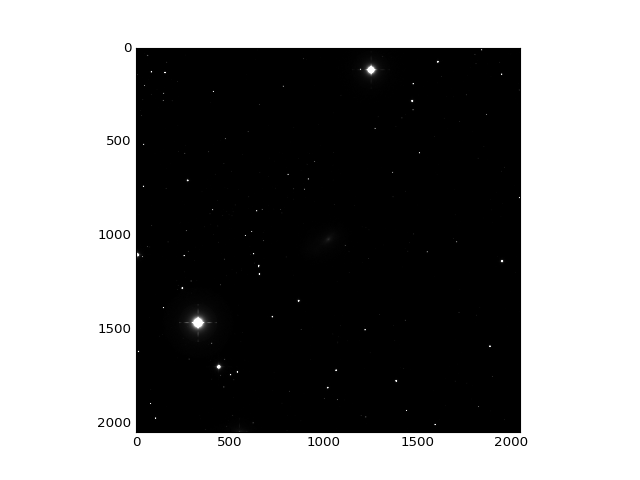

In [127]:
hdul = fits.open("/home/arturo/works/skymaker/myskys/Mochima/HR/MoSF1_face_B_HR.fits")
my_image = hdul[0].data
print my_image.min(),my_image.mean(), my_image.max()


fig, ax =plt.subplots()
ax.imshow(my_image, cmap='gray',vmin=3000,vmax=30000)


<IPython.core.display.Javascript object>


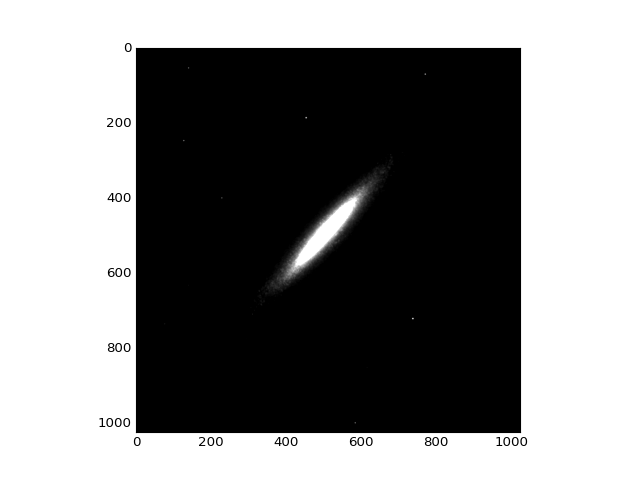

In [130]:
text_file = open("/home/arturo/works/skymaker/myskys/ChSF0_rot_R.txt", "w")
thismag = mag_R
the1, the2 = 0,0 
c1,s1 = np.cos(np.deg2rad(the1)),np.sin(np.deg2rad(the1))
c2,s2 = np.cos(np.deg2rad(the2)),np.sin(np.deg2rad(the2))
pos2 = np.copy(pos)
pos2[:,0] =  pos[:,0]*c1 - pos[:,1]*s1*c2 - pos[:,2]*s1*s2
pos2[:,1] = -pos[:,0]*s1 + pos[:,1]*c1*c2 - pos[:,2]*s2*c1
pos2[:,2] =  pos[:,1]*s2 + pos[:,2]*c2
pos = pos2
# calculates the ab magnitude of stars ar z = 0.0001
Dl = Planck15.luminosity_distance(0.001)
print Dl
# here we define the distance of each star to the observer
d = (pos[:,2]*1e3)+Dl.value * 1e6 # in parsecs
# Changin to pixel coords and centering the the galaxy in a picture of n_pixels
n_pixels, frame_size = 2048 , 30. # pixel, kpc
pos = (pos*n_pixels/frame_size) + [n_pixels/2.,n_pixels/2.,n_pixels/2.]
####################
f_d10 = 10**(-thismag[cut]/2.5)
f_d = f_d10*(10./d)**2
m_ab = -2.5* np.log10(f_d/3631)
print m_ab.min(),m_ab.mean(),m_ab.max()
mag = m_ab
ra = 500+np.rad2deg(np.arctan(pos[:,0]/(100-pos[:,2])))
dec = 500+np.rad2deg(np.arctan(pos[:,1]/(100-pos[:,2])))
for i in range(len(mag)):
    text_file.write("100 {0:.4f} {1:.4f} {2:.4f}\n".format(pos[i,0],pos[i,1],mag[i]))

text_file.close()



4.42903286476 Mpc
25.39382856536684 29.172372978814995 30.30106284226896
